In [2]:
import time
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC

In [3]:
dataset = pd.read_csv('./cleaned_dataset.csv', converters={'Tags': lambda x: eval(x)})
dataset

Body  \
0      uiimageview already image work fine later chan...   
1      possible duplicate delphi directory writeable ...   
2      requirement againstabout people allow close tr...   
3      keep getting could find base address match sch...   
4      xml simple gem inside rake task parse content ...   
...                                                  ...   
85483  possible singleton factory many domain factory...   
85484  wondering option keep resharper removing direc...   
85485  found getting started document developing apps...   
85486  area dot distributed area detect cluster dot a...   
85487  stylesheet writing actually generating differe...   

                                                    Tags  
0                         [iphone, uiimageview, uiimage]  
1                             [delphi, file-permissions]  
2                                         [c#, winforms]  
3                   [wcf, https, transport, credentials]  
4                                [ruby, xml, xml-simple]  
...                                                  ...  
85483                                             [java]  
85484  [c#, visual-studio-2008, resharper, using-dire...  
85485                                    [iphone, xcode]  
85486     [algorithm, data-structures, image-processing]  
85487                                             [xslt]  

[85488 rows x 2 columns]

# Vectorizing data

Plusieurs méthodes nous permettent de transformer ce bag-of-words en données numérique. Nous allons créer une fonction de preprocessing permettant de la choisir, afin de les tester de manières indépendantes.

In [4]:
class Algorithm(Enum):
    KMeans = 'kmeans'
    MiniBatchKmeans = 'minikmeans'
    DBSCAN = 'dbscan'


class Vectorizer(Enum):
    Count = 'count'
    TfIdf = 'tf-idf'


def preprocessing(dataset: pd.DataFrame, vectorizer: Vectorizer):
    """ Add features engineering to the dataset """
    max_features = 3000

    # CountVectorizer
    if vectorizer == Vectorizer.Count:
        count_vectorizer = CountVectorizer(lowercase=False, max_features=max_features)
        count_matrix = count_vectorizer.fit_transform(dataset['Body'])
        df = pd.DataFrame(count_matrix.toarray(), index=dataset.index,
                          columns=count_vectorizer.get_feature_names_out())
        df.reset_index(inplace=True, drop=True)

    # Tf-Idf
    elif vectorizer == Vectorizer.TfIdf:
        tf_vectorizer = TfidfVectorizer(lowercase=False, max_features=max_features)
        tf_matrix = tf_vectorizer.fit_transform(dataset['Body'])
        df = pd.DataFrame(tf_matrix.toarray(), index=dataset.index,
                          columns=tf_vectorizer.get_feature_names_out())
        df.reset_index(inplace=True, drop=True)

    n_components = 500
    pca = PCA(n_components=n_components)
    df_projected = pca.fit_transform(df)
    return (df_projected, df)


In [5]:
vectors = {name: preprocessing(dataset, vectorizer) for name, vectorizer in Vectorizer.__members__.items()}

# Unsupervized clustering

## KMeans
Pour ce test, nous utiliserons la version `MiniBatchKMeans` qui donne des résultats similaires mais permet une exécution beaucoup plus rapide. Nous passerons sur KMeans pour la production.

In [6]:
def kmeans_clusters(X):
    kelbow_viz = KElbowVisualizer(MiniBatchKMeans(random_state=5), k=(16, 24))
    kelbow_viz.fit(X)
    kelbow_viz.show()
    print(f'kelbow: {kelbow_viz.elbow_value_}')

    kmeans = MiniBatchKMeans(kelbow_viz.elbow_value_, random_state=5)
    kmeans.fit(X)
    labels = pd.Series(kmeans.labels_, name='cluster-label')
    value_dict = dict(labels.value_counts())
    value_counts = {str(k): int(v) for k, v in value_dict.items()}
    display(pd.Series(value_counts, name='clusters-size'))
    return labels

KMeans with Count


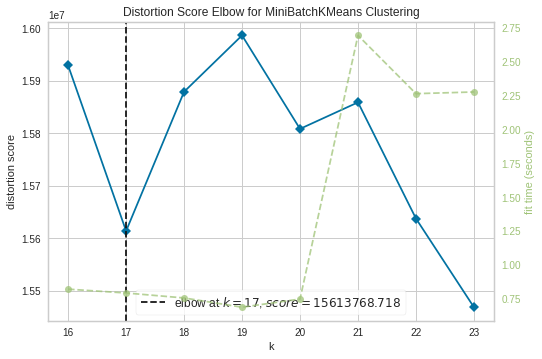

kelbow: 17


16    46028
10    25090
2      3137
4      1837
6      1693
12     1027
15      980
8       938
3       840
1       726
5       662
11      642
7       490
14      455
9       436
13      385
0       122
Name: clusters-size, dtype: int64

Execution time: 13.286129474639893s
KMeans with TfIdf


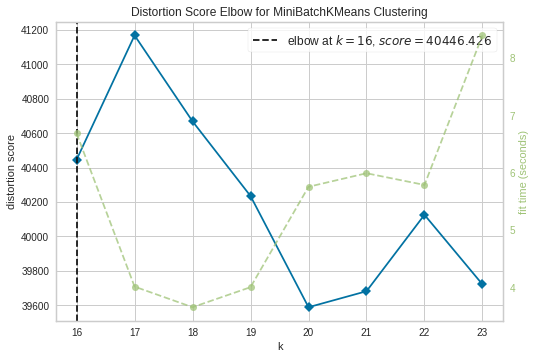

kelbow: 16


3     58298
13     7848
10     3273
2      2467
7      2236
12     2234
0      1914
14     1608
15     1457
9      1227
8      1113
4      1031
6       612
5       156
11       10
1         4
Name: clusters-size, dtype: int64

Execution time: 51.83216834068298s


In [7]:
kmeans_labels = {}
for name, vector in vectors.items():
    print(f'KMeans with {name}')
    start = time.time()
    kmeans_labels[name] = kmeans_clusters(vector[0])
    print(f'Execution time: {time.time() - start}s')


### Visualisation

In [8]:
import nltk

def get_top_tags(df, label, nb_tags=5):
    tagsFreq = df[df['cluster_label'] == label]['tags'].to_frame().apply(lambda x : pd.Series([x['tags'], nltk.FreqDist(x['tags'])], index=['tokens', 'frequency']), axis=1, result_type='expand')
    total_freq = {}
    for dictionnary in tagsFreq['frequency']:
        for k,v in dictionnary.items():
            if k in total_freq:
                total_freq[k] += v
            else:
                total_freq[k] = v

    freq_list = sorted(total_freq.items(), key=lambda x: x[1], reverse=True)
    return freq_list[:nb_tags]

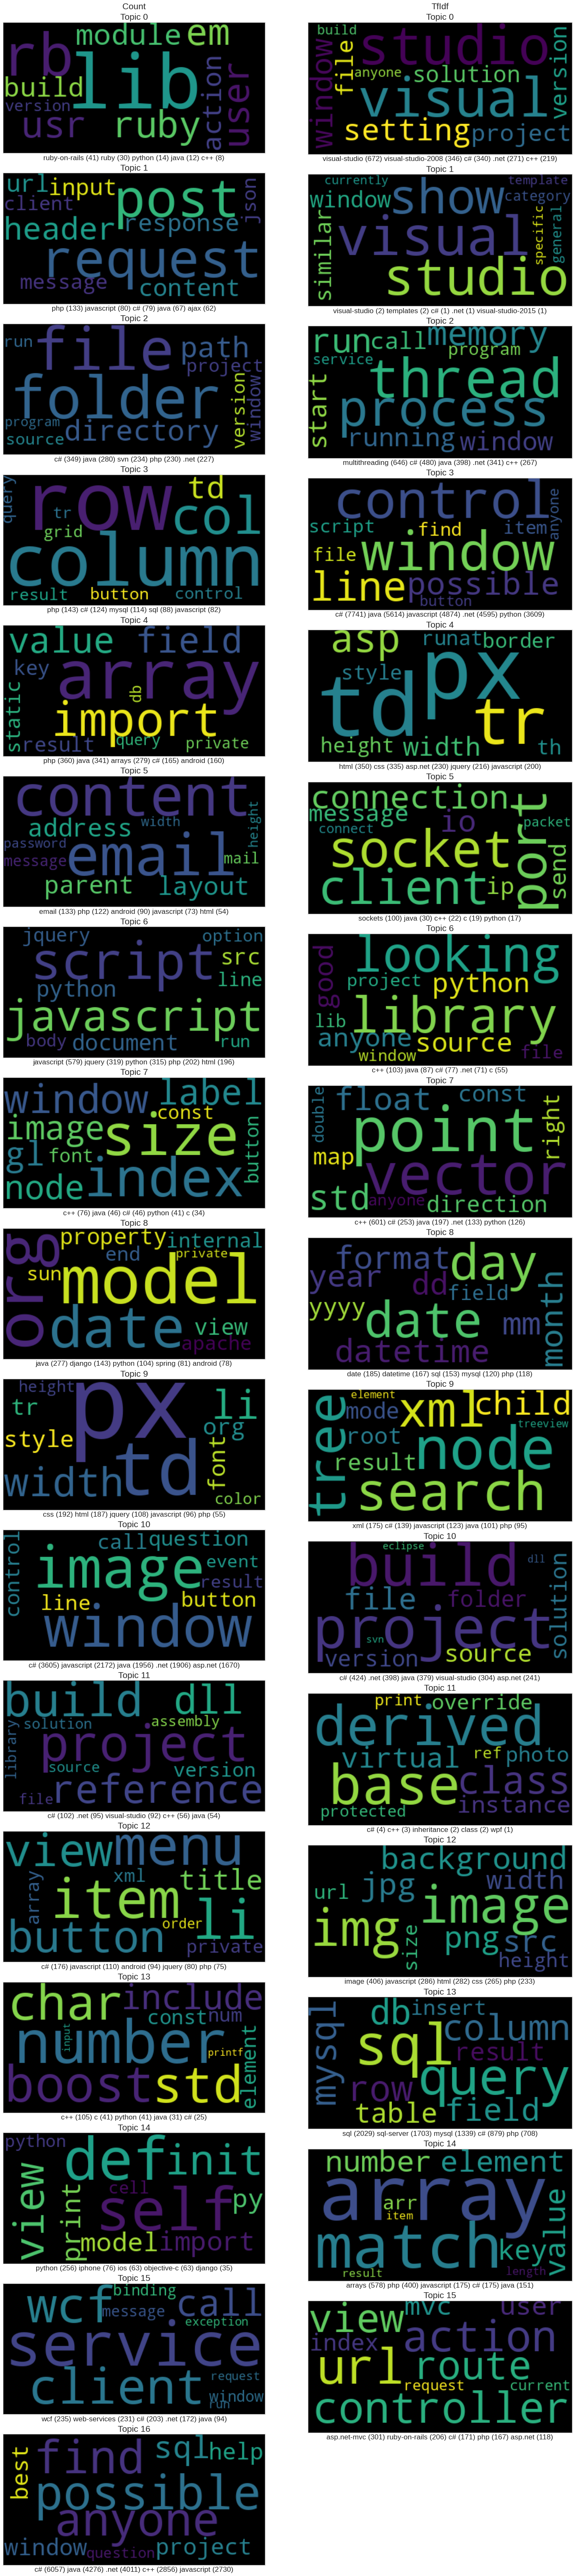

In [9]:
from wordcloud import WordCloud
n_cols = 2
n_rows = max([serie.max() for serie in kmeans_labels.values()]) + 1
fig = plt.figure(constrained_layout=True, figsize=(n_cols * 10 , n_rows * 5))
subfigures = fig.subfigures(1, len(kmeans_labels))
for vect_idx, (name, label) in enumerate(kmeans_labels.items()):
    dataset_labels = vectors[name][1].assign(cluster_label=label,
                           tags=dataset['Tags'])
    cluster_sum = dataset_labels.groupby('cluster_label').sum()
    subfigures[vect_idx].suptitle(name, fontsize='xx-large')
    for label_idx, label in enumerate(cluster_sum.index):
        top10_topics = cluster_sum.loc[label]\
                .sort_values(ascending=False)\
                .head(10).index.to_list()
        ax = subfigures[vect_idx].add_subplot(n_rows, 1, label_idx + 1)
        ax.set_title(f'Topic {label}', fontsize='xx-large')
        cloud = WordCloud().generate(' '.join(top10_topics))
        ax.imshow(cloud, interpolation='bilinear')
        ax.grid(False)
        ax.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
        ax.set_xlabel(' '.join([f'{tag} ({count})' for (tag, count) in get_top_tags(dataset_labels, label)]), fontsize='x-large')

plt.show()


### Scoring

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

for (name, vector), (_, labels) in zip(vectors.items(), kmeans_labels.items()):
    print(f'{name} Silhouette score : {silhouette_score(vector[0], labels)}')
    print(f'{name} Calinski-Harabasz score : {calinski_harabasz_score(vector[0], labels)}')
    print(f'{name} Davies-Bouldin score : {davies_bouldin_score(vector[0], labels)}')
    

Count Silhouette score : 0.10009526775380449
Count Calinski-Harabasz score : 345.8798774549375
Count Davies-Bouldin score : 5.34857586739731
TfIdf Silhouette score : 0.012805765901385045
TfIdf Calinski-Harabasz score : 264.55121748947505
TfIdf Davies-Bouldin score : 4.561268981468299


## DBSCAN

In [11]:
def make_dbscan_clusters(X):
    # Need to sample to avoid too much resources comsuption
    X_sample = X[0:30000]
    nb_neighbors = 10
    nearest_neighbors = NearestNeighbors(n_neighbors=nb_neighbors)
    nearest_neighbors.fit(X_sample)
    distances, _ = nearest_neighbors.kneighbors(X_sample)

    # Get max distance between neighbors
    max_distances = np.sort(distances[:, nb_neighbors - 1])

    # Find an elbow
    index = np.arange(len(max_distances))
    knee = KneeLocator(index, max_distances, curve='convex',
                       direction='increasing', interp_method='polynomial')
    knee.plot_knee(figsize=(10, 10))
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()

    dbscan = DBSCAN(min_samples=100, eps=knee.elbow_y)
    dbscan.fit(X_sample)
    print(f'Nombre de clusters : {len(dbscan.labels_)}')
    labels = pd.Series(dbscan.labels_, name='cluster-label')
    value_dict = dict(labels.value_counts())
    value_counts = {str(k): int(v) for k, v in value_dict.items()}
    display(pd.Series(value_counts, name='clusters-size'))
    return labels

DBSCAN with Count


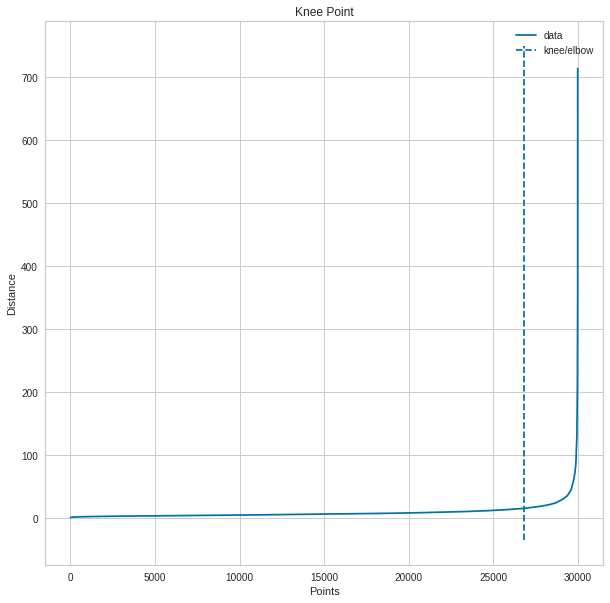

Nombre de clusters : 30000


0     27325
-1     2675
Name: clusters-size, dtype: int64

DBSCAN with TfIdf


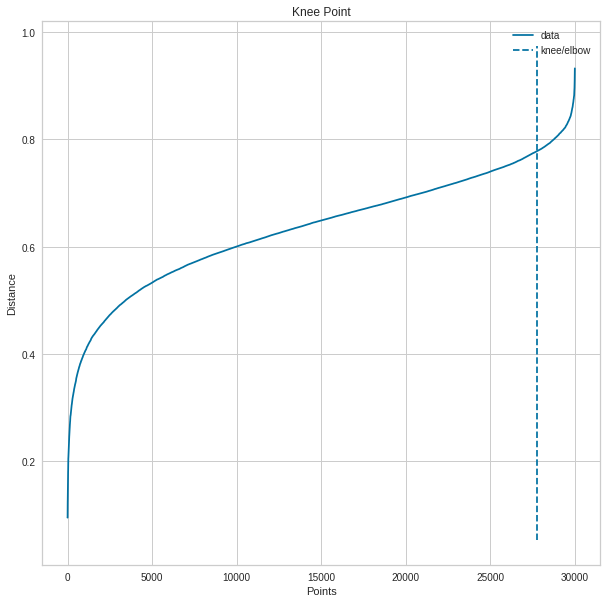

Nombre de clusters : 30000


0     29585
-1      415
Name: clusters-size, dtype: int64

In [12]:
dbscan_labels = {}
for name, vector in vectors.items():
    print(f'DBSCAN with {name}')
    dbscan_labels[name] = make_dbscan_clusters(vector[0])

DBSCAN ne semble pas à l'aise avec ces données et nécessite une puissance bien plus grande que KMeans. Nous allons donc le laisser de côté.

## Latent Dirichlet Allocation (LDA)

In [13]:
%%time
# Fix the number of topics near the KMeans elbow
no_topics = 17
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online',
                                         learning_offset=50., random_state=0).fit(vectors['Count'][1])

CPU times: user 1min, sys: 27.8 ms, total: 1min
Wall time: 1min


### Visualization

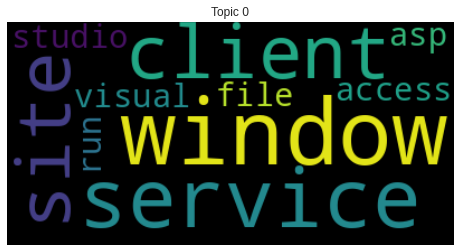

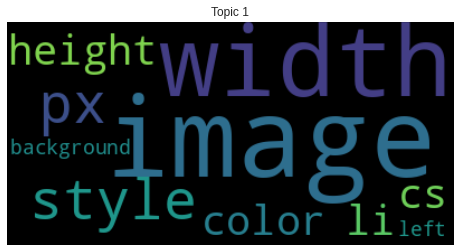

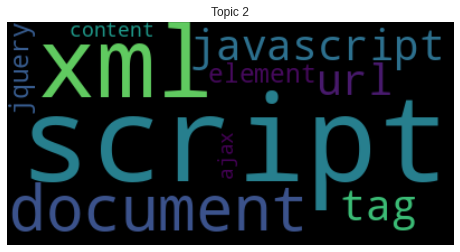

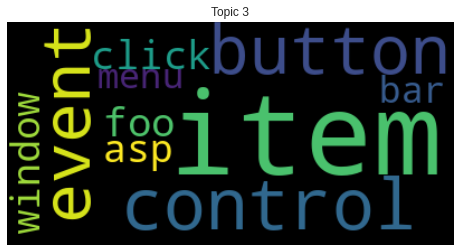

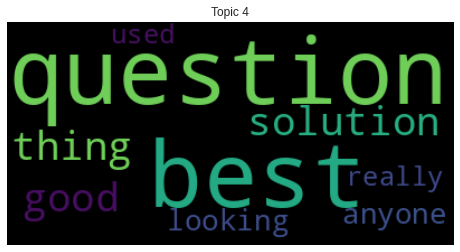

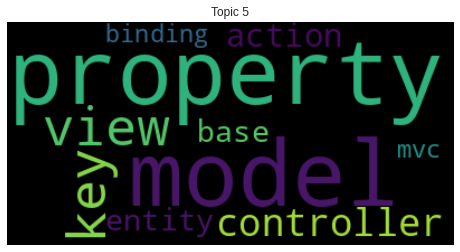

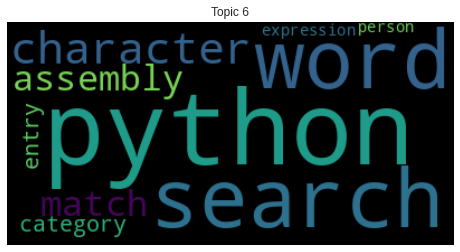

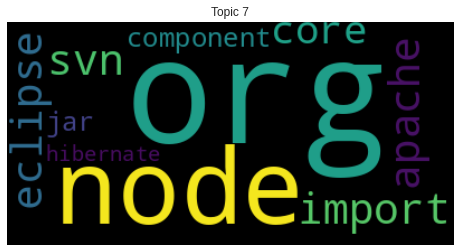

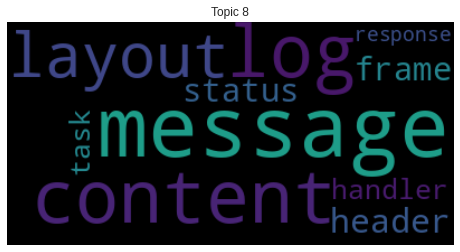

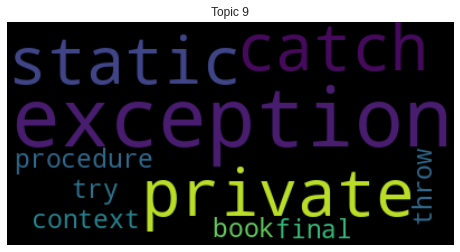

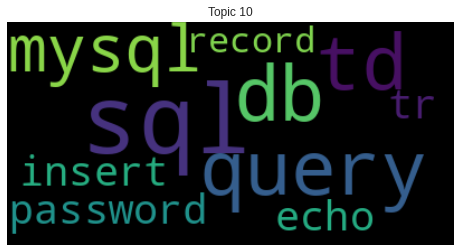

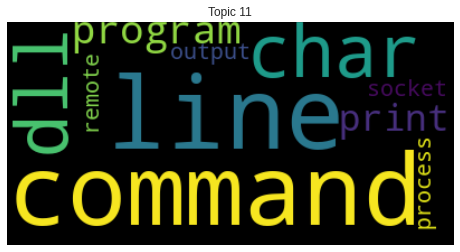

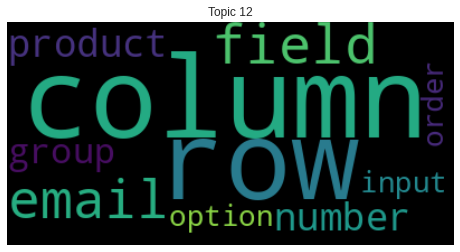

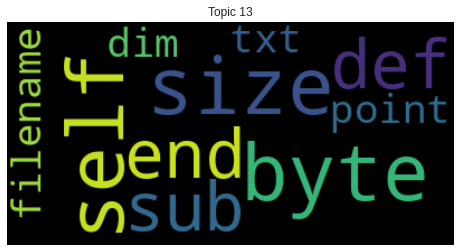

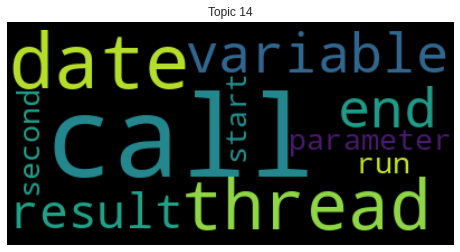

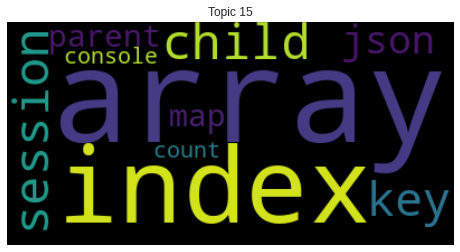

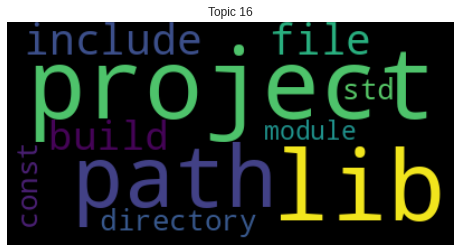

In [14]:
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    cloud = WordCloud().generate(" ".join([vectors['Count'][1].columns[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx}')
    plt.show()


## Scoring

In [15]:
print(f'Log-likelihood: {lda.score(vectors["Count"][1])}')
print(f'Perplexity: {lda.perplexity(vectors["Count"][1])}')

Log-likelihood: -28507975.63917534
Perplexity: 1120.2619386657557


# Supervized clustering

In [71]:
sample = 10000
X_train, X_test, y_train, y_test = train_test_split(vectors['Count'][0][:sample], dataset['Tags'].iloc[:sample], test_size=0.2, random_state=34)
mlb = MultiLabelBinarizer().fit(dataset['Tags'].iloc[:sample])
y_train = mlb.transform(y_train)
y_test = mlb.transform(y_test)

In [72]:
%%time
ovr = OneVsRestClassifier(LogisticRegression(n_jobs=-1, max_iter=500), n_jobs=-1)
ovr.fit(X_train, y_train)

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 8 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 16 is present in all training 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 327 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 331 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 358 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 362 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 363 is present in all t

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 646 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 648 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 651 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 652 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 682 is present in all t

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1029 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1031 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1036 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1048 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1056 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1329 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1336 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1341 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1347 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1352 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1586 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1607 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1618 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1638 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1643 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1892 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1912 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1913 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1927 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 1935 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2353 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2356 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2361 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2385 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2387 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2717 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2722 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2745 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2747 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2755 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2931 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2943 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2944 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2952 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 2958 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3225 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3239 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3250 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3261 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3263 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3534 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3542 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3557 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3570 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3572 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3820 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3826 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3828 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3874 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 3888 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4085 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4089 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4104 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4105 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4114 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4360 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4374 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4379 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4391 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4396 is present in 

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4701 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4703 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4739 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4744 is present in all training examples.
  warnings.warn(
/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 4752 is present in 

CPU times: user 32.6 s, sys: 3.77 s, total: 36.4 s
Wall time: 23min


OneVsRestClassifier(estimator=LogisticRegression(max_iter=500, n_jobs=-1),
                    n_jobs=-1)

In [73]:
%%time
ovr_score = ovr.score(X_test, y_test)
ovr_score

CPU times: user 7.91 s, sys: 14.4 s, total: 22.3 s
Wall time: 1.56 s


0.023

La stratégie OvR avec la régression logistique prend plusieurs heures. Il faut tester d'autres modele.

In [23]:
%%time
from sklearn.ensemble import RandomForestClassifier
ovr = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1), n_jobs=-1)
ovr.fit(X_train, y_train)

Process LokyProcess-64:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
KeyboardInterrupt


KeyboardInterrupt: 

In [24]:
%%time
ovr_score = ovr.score(X_test, y_test)
ovr_score

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

In [58]:
ovo = OneVsOneClassifier(SVC(), n_jobs=-1)
ovo.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (4000, 2916) instead.

In [ ]:
ovo_score = ovo.score(X_test, y_test)
ovo_score